In [1]:
from pprint import pprint
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import itertools
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

# pd.options.display.max_rows = 999

# Import the data
nyc_registry = pd.read_csv('../dogdata/NYC_Dog_Licensing_Dataset_2016-edit.csv')
coren = pd.read_csv('../dogdata/coren-edit.csv')
nyc_census = pd.read_csv('../censusdata/ACS_16_1YR_S0201_with_ann-edit.csv') # use 2016 data
edmonton_registry = pd.read_csv('../dogdata/Edmonton_Pet_Licenses_by_Neighbourhood_2018-edit.csv')
adelaide_registry = pd.read_csv('../dogdata/Dog_Registrations_Adelaide_2016-edit.csv')
wiki = pd.read_csv('../dogdata/wiki-edit.csv')
turcsan = pd.read_csv('../dogdata/turcsan.csv')

# List of attributes
lst = ['Bold', 'Calm', 'Obedient','Sociable', 'Trainable']
borough = ['Bronx','Brooklyn','Manhattan','Queens','Staten Island']
# Pare down the Coren data
coren = coren[['Breed', 'Obedient']]
# Combine the Coren and Turcsan datasets
attrib = coren.set_index('Breed').join(turcsan.set_index('Breed'), how='outer')


def describe(df, categ, filename=None, display=True):
    """Show the mean and standard deviation of the data and optionally plot. Optionally save a file of the plot.
    
    Arguments:
        df {DataFrame} -- DataFrame to describe
        categ {str} -- Display category
    
    Keyword Arguments:
        filename {str} -- Name of file to save to (default: {None})
        display {bool} -- Whether or not to display a plot (default: {True})
    """
    print('\n'+categ+' Mean')
    attrib_mean = df[lst].mean()
    print(attrib_mean.round(decimals=2))
    print('\n'+categ+' Standard Deviation')
    print(attrib[lst].std().round(decimals=2))

    plt.title(categ+' Overall Attributes')
    plt.bar(attrib_mean.index, attrib_mean.values)
    plt.ylim([0,0.65])
    if filename is not None:
        plt.savefig('../plots/'+filename)
    if display:
        plt.show()

def describe_breeds(save=False):
    '''Show the intersection of different breeds of dogs according to which dataset they come from. For example, Dogue de Bordeaux is in the Turcsan set but not in the Wiki scraped set.

    Returns:
        None
    '''
    wiki_breeds = set(wiki['Breed'].tolist())
    coren_breeds = set(coren['Breed'].tolist())
    turcsan_breeds = set(turcsan['Breed'].tolist())

    print('\nIntersection, Wiki and Turcsan')
    print(wiki_breeds & turcsan_breeds)
    print('\nIntersection, Wiki and Coren')
    print(wiki_breeds & coren_breeds)
    print('\nDifference, Wiki - Turcsan')
    print(wiki_breeds - turcsan_breeds)
    print('\nDifference, Turcsan - Wiki')
    print(turcsan_breeds - wiki_breeds)
    print('\nDifference, Wiki - Coren')
    print(wiki_breeds - coren_breeds)
    print('\nDifference, Coren - Wiki')
    print(coren_breeds - wiki_breeds)

def plot_by_attrib(df, categ,label, filename=None, display=True):
    """Plot a graph by the attributes provided.
    
    Arguments:
        df {DataFrame} -- DF to plot
        categ {list} -- Categories to plot
        label {str} -- Label for what the data is describing
    
    Keyword Arguments:
        filename {str} -- Name of the file to optionally save (default: {None})
        display {bool} -- Whether or not to display the plot (default: {True})
    """
    fig, ax = plt.subplots()
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right', rotation_mode='anchor')
    for item in categ:
        ax.plot(df.index, df[item])

    plt.gcf().subplots_adjust(bottom=0.3, right=.75)
    plt.legend(loc=(1.04,0.6))
    plt.title('Scores by '+ label)
    ax.set_ylabel('Score')
    ax.set_xlabel(label)
    if filename is not None:
        plt.savefig('../plots/'+filename)
    if display:
        plt.show()


def splitDataFrameList(df,target_column,separator):
    """Thanks to James Allen, https://gist.github.com/jlln/338b4b0b55bd6984f883
    
    Arguments:
        df {DataFrame} -- DataFrame to split,
        target_column {string} -- The column containing the values to split
        separator {str} -- The symbol used to perform the split
    
    Returns:
        DataFrame -- A dataframe with each entry for the target column separated, with each element moved into a new row. 
    The values in the other columns are duplicated across the newly divided rows.
    """
    def splitListToRows(row,row_accumulator,target_column,separator):
        split_row = row[target_column].split(separator)
        for s in split_row:
            new_row = row.to_dict()
            new_row[target_column] = s
            row_accumulator.append(new_row)
    new_rows = []
    df.apply(splitListToRows,axis=1,args = (new_rows,target_column,separator))
    new_df = pd.DataFrame(new_rows)
    return new_df

In [2]:
# Show which dogs are in each dataset.
describe_breeds()


Intersection, Wiki and Turcsan
{'Bull Terrier', 'Miniature Poodle', 'Beauceron', 'Vizsla', 'Poodle', 'Whippet', 'Pointer', 'Ibizan Hound', 'Welsh Terrier', 'Doberman Pinscher', 'Belgian Malinois', 'Dachshund', 'Weimaraner', 'Airedale Terrier', 'Old English Sheepdog', 'Irish Terrier', 'Boxer', 'German Shorthaired Pointer', 'Bernese Mountain Dog', 'Irish Setter', 'Standard Schnauzer', 'Great Dane', 'Irish Wolfhound', 'Jack Russell Terrier', 'Australian Shepherd', 'Brittany', 'Flat-Coated Retriever', 'Polish Lowland Sheepdog', 'Staffordshire Bull Terrier', 'Tibetan Terrier', 'English Setter', 'Coton de Tulear', 'Pekingese', 'Siberian Husky', 'Shar Pei', 'Beagle', 'American Staffordshire Terrier', 'Shiba Inu', 'Cairn Terrier', 'Saint Bernard', 'Pug', 'Labrador Retriever', 'Bearded Collie', 'Rottweiler', 'Alaskan Malamute', 'Rhodesian Ridgeback', 'Shetland Sheepdog', 'Dalmatian', 'French Bulldog', 'German Wirehaired Pointer', 'Golden Retriever', 'German Shepherd', 'Bulldog', 'Briard', 'Cav


AKC Mean
              Obedient  Calm  Trainable  Sociable  Bold
AKC                                                    
Herding           0.77  0.30       0.85      0.45  0.30
Hound             0.40  0.50       0.67      0.58  0.33
Non-Sporting      0.51  0.44       0.67      0.44  0.22
Sporting          0.73  0.67       0.62      0.67  0.62
Terrier           0.51  0.30       0.75      0.30  0.35
Toy               0.40  0.62       0.25      0.56  0.69
Working           0.60  0.45       0.73      0.41  0.36

AKC Standard Deviation
              Obedient  Calm  Trainable  Sociable  Bold
AKC                                                    
Herding           0.20  0.48       0.24      0.44  0.48
Hound             0.21  0.55       0.41      0.38  0.52
Non-Sporting      0.26  0.53       0.43      0.39  0.44
Sporting          0.15  0.49       0.38      0.44  0.48
Terrier           0.17  0.48       0.35      0.48  0.47
Toy               0.23  0.52       0.27      0.50  0.37
Working       

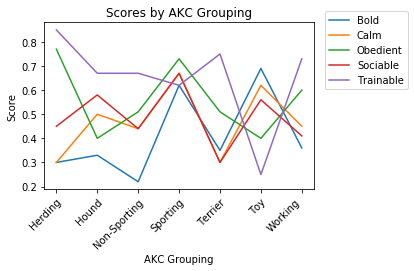

In [3]:
# Canine attributes by AKC groupings
wiki_akc = wiki[['Breed', 'AKC']]
akc_groups_attrib = wiki_akc.set_index('Breed').join(attrib, how='left')
print('\nAKC Mean')
akc = akc_groups_attrib.groupby('AKC').mean().round(decimals=2)
pprint(akc)
print('\nAKC Standard Deviation')
akc_std = akc_groups_attrib.groupby('AKC').std().round(decimals=2)
pprint(akc_std)
print('\nAKC Count')
akc_count = akc_groups_attrib.groupby('AKC').count()
pprint(akc_count)

# Plot the AKC grouping data
plot_by_attrib(akc, lst, 'AKC Grouping')

In [4]:
# Strip out NYC dirty values
nyc_registry['Borough'] = nyc_registry['Borough'].map(lambda x: None if x not in {'Brooklyn', 'Bronx', 'Staten Island', 'Manhattan', 'Queens'} else x)
nyc_registry['BreedName'] = nyc_registry['BreedName'].map(lambda x: None if x == 'Unknown' else x)
nyc_registry.dropna(inplace=True)

# Display breed attributes by NYC borough
display = False
norm=False # Do not normalize
nyc_attrib = nyc_registry.set_index('BreedName').join(attrib, how='left')
nyc_attrib = nyc_attrib[['Borough','Calm', 'Trainable', 'Sociable', 'Bold', 'Obedient']]
nyc_attrib_g = nyc_attrib.groupby('Borough')
print('\nNYC Mean:')
nyc_attrib_g_mean = nyc_attrib_g.mean()
pprint(nyc_attrib_g_mean.round(decimals=2))
print('\nNYC Standard Deviation:')
pprint(nyc_attrib_g.std().round(decimals=2))
print('\nNYC Count:')
pprint(nyc_attrib_g.count())
if display:
    plot_by_attrib(nyc_attrib_g_mean, lst, 'NYC Borough')

nyc_breeds = nyc_registry[['Borough', 'BreedName']]
print('\nTop NYC Dogs Count')
pprint(nyc_breeds['BreedName'].value_counts().nlargest(5))
nyc_breeds_grp = nyc_breeds.groupby('Borough')
print('\nTop Dogs By Borough')
for b in borough:
    print('\n'+b)
    print(nyc_breeds_grp.get_group(b)['BreedName'].value_counts(normalize=norm).head(5))


NYC Mean:
               Calm  Trainable  Sociable  Bold  Obedient
Borough                                                 
Bronx          0.38       0.37      0.38  0.59      0.51
Brooklyn       0.46       0.42      0.46  0.60      0.48
Manhattan      0.49       0.47      0.51  0.62      0.52
Queens         0.40       0.40      0.42  0.58      0.51
Staten Island  0.57       0.44      0.57  0.68      0.54

NYC Standard Deviation:
               Calm  Trainable  Sociable  Bold  Obedient
Borough                                                 
Bronx          0.49       0.38      0.48  0.37      0.28
Brooklyn       0.50       0.37      0.48  0.39      0.28
Manhattan      0.50       0.36      0.49  0.41      0.27
Queens         0.49       0.38      0.48  0.38      0.28
Staten Island  0.50       0.33      0.48  0.39      0.31

NYC Count:
               Calm  Trainable  Sociable  Bold  Obedient
Borough                                                 
Bronx           312        312       312

In [5]:
# Perform Chi-Square analysis on NYC data
chi2_breed = ['Yorkshire Terrier', 'Shih Tzu','Chihuahua', 'Maltese', 'Labrador Retriever']
chi2_breed_com = itertools.combinations(chi2_breed, 2)
nyc_breeds_5 = nyc_registry[nyc_registry['BreedName'].isin(chi2_breed)] #top 5 breeds overall
for i in chi2_breed_com:
    print('\n',i)
    nyc_breeds_2 = nyc_registry[nyc_registry['BreedName'].isin(i)]
    contingency_table = pd.crosstab(nyc_breeds_2['BreedName'], nyc_breeds_2['Borough'])
    nyc_chi2 = stats.chi2_contingency(contingency_table)
    print('Test statistic: {}'.format(nyc_chi2[0].round(2)))
    print('P-value: {}'.format(nyc_chi2[1]))


 ('Yorkshire Terrier', 'Shih Tzu')
Test statistic: 7.48
P-value: 0.11246266909805729

 ('Yorkshire Terrier', 'Chihuahua')
Test statistic: 5.73
P-value: 0.22045859628948278

 ('Yorkshire Terrier', 'Maltese')
Test statistic: 7.79
P-value: 0.09962354106879621

 ('Yorkshire Terrier', 'Labrador Retriever')
Test statistic: 36.72
P-value: 2.0576949641080475e-07

 ('Shih Tzu', 'Chihuahua')
Test statistic: 13.69
P-value: 0.008345675309120405

 ('Shih Tzu', 'Maltese')
Test statistic: 12.44
P-value: 0.014356090629419813

 ('Shih Tzu', 'Labrador Retriever')
Test statistic: 25.54
P-value: 3.911272554107337e-05

 ('Chihuahua', 'Maltese')
Test statistic: 4.86
P-value: 0.30219516255729534

 ('Chihuahua', 'Labrador Retriever')
Test statistic: 32.99
P-value: 1.2002297511683226e-06

 ('Maltese', 'Labrador Retriever')
Test statistic: 33.91
P-value: 7.780629645938062e-07


In [6]:
# Perform t-tests on NYC data
print('Alternative Hypothesis: dogs from Staten Island are bolder than other dogs in New York.')

non_staten = nyc_attrib[nyc_attrib['Borough'].isin(['Manhattan', 'Queens', 'Bronx', 'Brooklyn'])]
non_staten.dropna(inplace=True)
non_staten_bold = non_staten['Bold']
staten = nyc_attrib[nyc_attrib['Borough'] == 'Staten Island']
staten.dropna(inplace=True)
staten_bold = staten['Bold']
print(stats.ttest_ind(staten_bold, non_staten_bold, equal_var = False))

print('Alternative Hypothesis: dogs from Staten Island are calmer than other dogs in New York.')
non_staten_calm = non_staten['Calm']
staten_calm = staten['Calm']
print(stats.ttest_ind(staten_calm, non_staten_calm, equal_var = False))

print('Alternative Hypothesis: dogs from New York are bolder than dogs in Adelaide and Edmonton.')
adelaide_attrib = adelaide_registry.set_index('AnimalBreed').join(attrib, how='left')
edmonton_attrib = edmonton_registry.set_index('BREED').join(attrib, how='left')
nyc_bold = nyc_attrib['Bold']
nyc_bold.dropna(inplace=True)
ad_ed_attrib = pd.concat([adelaide_attrib, edmonton_attrib])
ad_ed_bold = ad_ed_attrib['Bold']
ad_ed_bold.dropna(inplace=True)
print(stats.ttest_ind(nyc_bold, ad_ed_bold, equal_var = False))

print('Alternative Hypothesis: dogs from Edmonton are more obedient than dogs\n \
in Adelaide and New York.')
nyc_obedient = nyc_attrib['Obedient']
nyc_obedient.dropna(inplace=True)
ad_ed_obedient = ad_ed_attrib['Obedient']
ad_ed_obedient.dropna(inplace=True)
print(ad_ed_obedient.value_counts())
print(stats.ttest_ind(nyc_obedient, ad_ed_obedient, equal_var = False))

Alternative Hypothesis: dogs from Staten Island are bolder than other dogs in New York.
Ttest_indResult(statistic=3.435544629492364, pvalue=0.0006561220278463945)
Alternative Hypothesis: dogs from Staten Island are calmer than other dogs in New York.
Ttest_indResult(statistic=3.8462844628779225, pvalue=0.00014058887400346439)
Alternative Hypothesis: dogs from New York are bolder than dogs in Adelaide and Edmonton.


/Users/sandbar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/sandbar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/sandbar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Ttest_indResult(statistic=6.039372226991816, pvalue=1.7169589349976154e-09)
Alternative Hypothesis: dogs from Edmonton are more obedient than dogs
 in Adelaide and New York.
0.95    18352
0.50    14161
0.30     9479
0.10     8138
0.70     4515
0.85     4317
Name: Obedient, dtype: int64
Ttest_indResult(statistic=-16.577408935991556, pvalue=9.746066231426407e-60)



NYC Mean
Bold         0.61
Calm         0.46
Obedient     0.51
Sociable     0.47
Trainable    0.43
dtype: float64

NYC Standard Deviation
Bold         0.46
Calm         0.50
Obedient     0.24
Sociable     0.43
Trainable    0.38
dtype: float64


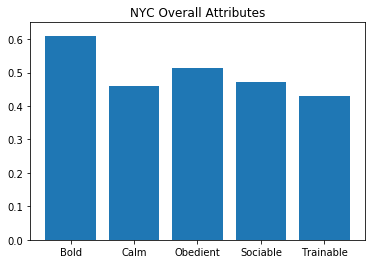


Adelaide Mean
Bold         0.47
Calm         0.35
Obedient     0.52
Sociable     0.35
Trainable    0.52
dtype: float64

Adelaide Standard Deviation
Bold         0.46
Calm         0.50
Obedient     0.24
Sociable     0.43
Trainable    0.38
dtype: float64


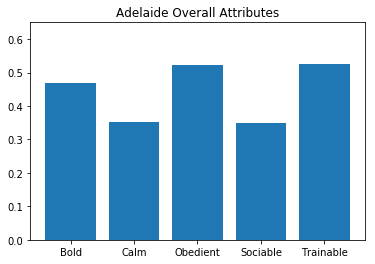


Edmonton Mean
Bold         0.58
Calm         0.52
Obedient     0.61
Sociable     0.52
Trainable    0.58
dtype: float64

Edmonton Standard Deviation
Bold         0.46
Calm         0.50
Obedient     0.24
Sociable     0.43
Trainable    0.38
dtype: float64


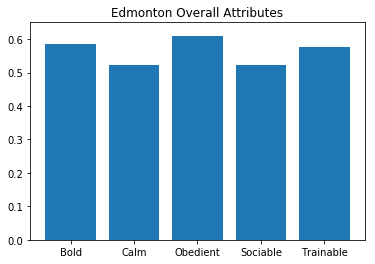

In [7]:
# Show data on NYC, Adelaide, and Edmonton
describe(nyc_attrib, 'NYC')
describe(adelaide_attrib, 'Adelaide')
describe(edmonton_attrib, 'Edmonton')

adelaide_mean = adelaide_attrib[lst].mean()
edmonton_mean = edmonton_attrib[lst].mean()
nyc_mean = nyc_attrib[lst].mean()

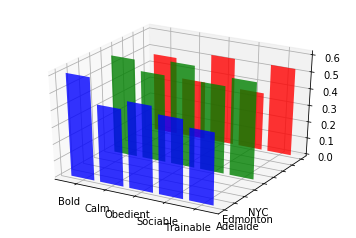

In [8]:
#3D Plot
fig1 = plt.figure()
ax1 = fig1.add_subplot(111, projection='3d')
xs = np.arange(5)
ys = adelaide_mean.values
cs = 'r' * 5
ax1.bar(xs, ys, zs=3, zdir='y', color=cs, alpha=0.8)
ys = edmonton_mean.values
cs = 'g' * 5
ax1.bar(xs, ys, zs=2, zdir='y', color=cs, alpha=0.8 )
ys = nyc_mean.values
cs = 'b' * 5
ax1.bar(xs, ys, zs=1, zdir='y', color=cs, alpha=0.8)

ax1.w_xaxis.set_ticklabels(lst)
ax1.w_yaxis.set_ticklabels(['Adelaide','Edmonton','NYC'])

plt.show()


UK and Ireland Mean
          Obedient  Calm  Trainable  Sociable  Bold
Origin                                             
England       0.51  0.70        0.4      0.65   0.7
Ireland       0.62  0.75        0.5      0.62   0.5
Scotland      0.59  0.80        0.6      0.80   0.8
Wales         0.59  0.00        1.0      0.00   0.0

UK and Ireland Standard Deviation
          Obedient  Calm  Trainable  Sociable  Bold
Origin                                             
England       0.21  0.48       0.32      0.47  0.42
Ireland       0.15  0.50       0.41      0.48  0.58
Scotland      0.25  0.45       0.22      0.45  0.45
Wales         0.24   NaN        NaN       NaN   NaN

UK and Ireland Count
          Obedient  Calm  Trainable  Sociable  Bold
Origin                                             
England         19    10         10        10    10
Ireland          6     4          4         4     4
Scotland        10     5          5         5     5
Wales            4     1          1   

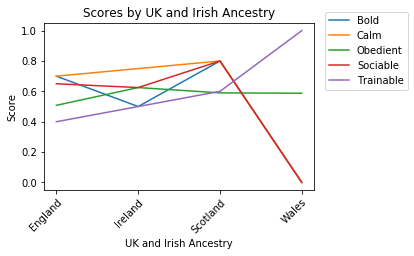


Ancestral Origin Mean, n>2
                Bold  Calm  Obedient  Sociable  Trainable
Origin                                                   
China           0.50  0.83      0.27      0.67       0.42
France          0.38  0.25      0.70      0.38       0.62
Germany         0.08  0.08      0.75      0.12       1.00
Ireland         0.50  0.75      0.55      0.62       0.50
United Kingdom  0.68  0.68      0.61      0.66       0.57
United States   0.00  0.33      0.57      0.17       0.67

Ancestral Origin Standard Deviation
                Bold  Calm  Obedient  Sociable  Trainable
Origin                                                   
China           0.55  0.41      0.15      0.41       0.38
France          0.48  0.50      0.29      0.48       0.48
Germany         0.29  0.29      0.20      0.31       0.00
Ireland         0.58  0.50      0.10      0.48       0.41
United Kingdom  0.45  0.48      0.25      0.47       0.32
United States   0.00  0.58      0.12      0.29       0.58

Ancest

/Users/sandbar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


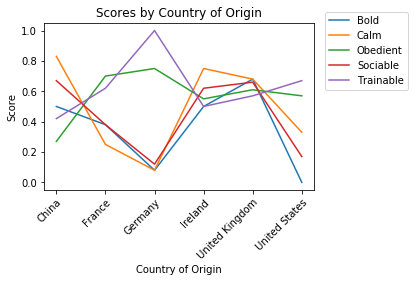

In [9]:
# Looking at the UK and Ireland
ancestral = wiki[['Breed', 'Origin']]
ancestral_uk_ire = ancestral.copy()
ancestral_uk_ire.dropna(inplace=True)
ancestral_uk_ire = ancestral_uk_ire[ancestral_uk_ire['Origin'].isin(['England', 'Scotland', 'Wales', 'Ireland'])]
ancestral_uk_ire = ancestral_uk_ire.set_index('Breed').join(attrib, how='inner')
ancestral_uk_ire_grp = ancestral_uk_ire.groupby('Origin')
ancestral_uk_ire_mean = ancestral_uk_ire_grp.mean()
print('\nUK and Ireland Mean')
print(ancestral_uk_ire_grp.mean().round(decimals=2))
print('\nUK and Ireland Standard Deviation')
print(ancestral_uk_ire_grp.std().round(decimals=2))
print('\nUK and Ireland Count')
print(ancestral_uk_ire_grp.count())

# Plot the UK and Ireland data
plot_by_attrib(ancestral_uk_ire_mean, lst, 'UK and Irish Ancestry')

# Combining Scotland, Wales, and England as United Kingdom
ancestral['Origin'] = ancestral['Origin'].map(lambda x: 'United Kingdom' if x in {'England', 'Wales', 'Scotland'} else x)
ancestral_attrib = ancestral.set_index('Breed').join(attrib, how='inner')

# Show data on attributes of dogs given their ancestral home
ancestral_attrib.dropna(inplace=True)
ancestral_attrib2 = splitDataFrameList(ancestral_attrib,'Origin', '/')
ancestral_attrib2['Origin'] = ancestral_attrib2['Origin'].map(lambda x: 'China' if x == 'Tibet (China)' else x)
ancestral_attrib_grp = ancestral_attrib2.groupby('Origin')
ancestral_attrib_count = ancestral_attrib_grp.count()
ancestral_attrib_mean = ancestral_attrib_grp.mean().round(decimals=2)
ancestral_attrib_std = ancestral_attrib_grp.std().round(decimals=2)

# Only display values where there are more than two dogs
ancestral_attrib_mean_filtered = ancestral_attrib_mean[ancestral_attrib_count['Bold'] > 2]
ancestral_attrib_std_filtered = ancestral_attrib_std[ancestral_attrib_count['Bold'] > 2]

print('\nAncestral Origin Mean, n>2')
pprint(ancestral_attrib_mean_filtered)
print('\nAncestral Origin Standard Deviation')
pprint(ancestral_attrib_std_filtered)
print('\nAncestral Origin Count')
pprint(ancestral_attrib_count)

# Plot by country of origin
plot_by_attrib(ancestral_attrib_mean_filtered, lst, 'Country of Origin')

In [10]:
print('Alternative Hypothesis: Dogs with ancestry from the UK are bolder than other dogs.')
ancestral_uk = ancestral_attrib2[ancestral_attrib2['Origin'] == 'United Kingdom']
ancestral_not_uk = ancestral_attrib2[~(ancestral_attrib2['Origin'] == 'United Kingdom')]
ancestral_uk_bold = ancestral_uk['Bold']
print('Ancestral UK Bold Mean:')
print(ancestral_uk_bold.mean())
ancestral_uk_bold.dropna(inplace=True)
ancestral_not_uk_bold = ancestral_not_uk['Bold']
ancestral_not_uk_bold.dropna(inplace=True)
print('Ancestral Non-UK Bold Mean:')
print(ancestral_not_uk_bold.mean())
print(stats.ttest_ind(ancestral_uk_bold, ancestral_not_uk_bold, equal_var = False))

/Users/sandbar/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:3896: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)


Alternative Hypothesis: Dogs with ancestry from the UK are bolder than other dogs.
Ancestral UK Bold Mean:
0.6818181818181818
Ancestral Non-UK Bold Mean:
0.313953488372093
Ttest_indResult(statistic=3.1133301873945967, pvalue=0.00331078574427337)


In [11]:
print('Null Hypothesis: The average obedience of UK dogs is the same as non-UK dogs.')
print('Alternative Hypothesis: The average obedience of UK dogs is different from non-UK dogs.')
ancestral_uk_obedient = ancestral_uk['Obedient']
ancestral_not_uk_obedient = ancestral_not_uk['Obedient']
print(stats.ttest_ind(ancestral_uk_obedient, ancestral_not_uk_obedient, equal_var = False))

Null Hypothesis: The average obedience of UK dogs is the same as non-UK dogs.
Alternative Hypothesis: The average obedience of UK dogs is different from non-UK dogs.
Ttest_indResult(statistic=0.22598874581524203, pvalue=0.8223196147677269)


## German dogs

In [16]:
print('Alternative Hypothesis: Dogs with German ancestry are more obedient than other dogs.')
ancestral_ger = ancestral_attrib2[ancestral_attrib2['Origin'] == 'Germany']
ancestral_not_ger = ancestral_attrib2[~(ancestral_attrib2['Origin'] == 'Germany')]
ancestral_ger_obedient = ancestral_ger['Obedient']
print('Ancestral Germany Obedient Mean:')
print(ancestral_ger_obedient.mean())
ancestral_ger_obedient.dropna(inplace=True)
ancestral_not_ger_obedient = ancestral_not_ger['Obedient']
ancestral_not_ger_obedient.dropna(inplace=True)
print('Ancestral Non-Germany Obedient Mean:')
print(ancestral_not_ger_obedient.mean())
print(stats.ttest_ind(ancestral_ger_obedient, ancestral_not_ger_obedient, equal_var = False))

Alternative Hypothesis: Dogs with German ancestry are more obedient than other dogs.
Ancestral Germany Obedient Mean:
0.7541666666666668
Ancestral Non-Germany Obedient Mean:
0.5613207547169812
Ttest_indResult(statistic=2.8770141108829277, pvalue=0.009547953620993713)


/Users/sandbar/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:3896: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)


In [17]:
print('Alternative Hypothesis: Dogs with German ancestry are less calm than other dogs.')
ancestral_ger_calm = ancestral_ger['Calm']
print('Ancestral Germany Calm Mean:')
print(ancestral_ger_calm.mean())
ancestral_ger_calm.dropna(inplace=True)
ancestral_not_ger_calm = ancestral_not_ger['Calm']
ancestral_not_ger_calm.dropna(inplace=True)
print('Ancestral Non-Germany Calm Mean:')
print(ancestral_not_ger_calm.mean())
print(stats.ttest_ind(ancestral_ger_calm, ancestral_not_ger_calm, equal_var = False))

Alternative Hypothesis: Dogs with German ancestry are less calm than other dogs.
Ancestral Germany Calm Mean:
0.08333333333333333
Ancestral Non-Germany Calm Mean:
0.5660377358490566
Ttest_indResult(statistic=-4.468667004142404, pvalue=0.00011605889988818817)


/Users/sandbar/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:3896: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
